**Train custom LLM with the genomics data which in Knowledge graph using quantum circuit leveraging Google Cirq package**

This repository offers an end-to-end example of a hybrid quantum-classical model built with PyTorch and Cirq, integrating a variational quantum circuit enhanced with a bit-flip error correction scheme for processing synthetic genomics data. The code includes detailed visualizations—such as quantum circuit diagrams, a training loss curve, and a confusion matrix—to aid in model evaluation. Additionally, it incorporates a knowledge graph component to enrich data representation and improve model performance.

Install Dependencies
This cell installs all the required packages.

In [41]:

# Install required packages
!pip install cirq torch scikit-learn

Import Libraries & Define Synthetic Data Loader
This cell imports necessary libraries and defines a function to generate synthetic genomics features and labels (as a stand‐in for data from your knowledge graph).

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cirq
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def load_genomics_kg_features(num_samples=200, feature_dim=16, threshold=4.0):
    """
    Generate synthetic features and labels with a signal.
    Label is 1 if the sum of the first half of the features > threshold, else 0.
    """
    features = np.random.rand(num_samples, feature_dim).astype(np.float32) * 2  # scale to [0, 2)
    # Compute sum over first half of features for each sample.
    signal = np.sum(features[:, :feature_dim//2], axis=1)
    labels = (signal > threshold).astype(np.int64)
    features_tensor = torch.tensor(features)
    labels_tensor = torch.tensor(labels)
    print(f"Loaded synthetic features with shape: {features_tensor.shape}")
    print(f"Loaded synthetic labels with shape: {labels_tensor.shape}")
    return features_tensor, labels_tensor

# Test synthetic data loader
features, labels = load_genomics_kg_features()



Loaded synthetic features with shape: torch.Size([200, 16])
Loaded synthetic labels with shape: torch.Size([200])


Define the Standard Variational Quantum Circuit
This cell defines functions to create and simulate a basic 2‑qubit variational circuit using Cirq.

In [43]:
def create_quantum_circuit(params):
    """
    Build a simple 2-qubit variational quantum circuit.
    Args:
        params: 1D numpy array of length 4.
    Returns:
        circuit: a Cirq Circuit.
        qubits: list of two Cirq qubits.
    """
    qubits = [cirq.GridQubit(0, i) for i in range(2)]
    circuit = cirq.Circuit()
    # First layer: RX rotations
    for i, q in enumerate(qubits):
        circuit.append(cirq.rx(params[i])(q))
    # Entangling layer: CNOT gate
    circuit.append(cirq.CNOT(qubits[0], qubits[1]))
    # Second layer: RY rotations
    for i, q in enumerate(qubits):
        circuit.append(cirq.ry(params[i+2])(q))
    return circuit, qubits

def simulate_quantum_circuit(params):
    """
    Simulate the circuit and return expectation values in the Z basis.
    """
    circuit, qubits = create_quantum_circuit(params)
    # Add measurement operations
    for i, q in enumerate(qubits):
        circuit.append(cirq.measure(q, key=f'm{i}'))

    print("Standard Quantum Circuit Diagram:")
    print(circuit)

    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=100)

    print("\nMeasurement Results (raw counts):")
    print(result)

    exp_vals = []
    for i in range(len(qubits)):
        measurements = result.measurements[f'm{i}']
        # 0 -> +1, 1 -> -1
        exp_val = np.mean(1 - 2 * measurements)
        exp_vals.append(exp_val)
    print("\nComputed Expectation Values (Z basis):", exp_vals)
    return np.array(exp_vals, dtype=np.float32)

# Demo the standard circuit
print("\n--- Demo: Standard Quantum Circuit ---")
sample_params = np.array([0.1, 0.2, 0.3, 0.4], dtype=np.float32)
_ = simulate_quantum_circuit(sample_params)



--- Demo: Standard Quantum Circuit ---
Standard Quantum Circuit Diagram:
(0, 0): ───Rx(0.032π)───@───Ry(0.095π)───M('m0')───
                        │
(0, 1): ───Rx(0.064π)───X───Ry(0.127π)───M('m1')───

Measurement Results (raw counts):
m0=0000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000
m1=0000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000

Computed Expectation Values (Z basis): [0.98, 0.98]


Define the Error-Corrected Quantum Circuit
This cell defines a simple bit‑flip error correction scheme using a 3‑qubit encoding per logical qubit.

In [44]:
def create_quantum_circuit(params):
    """
    Build a simple 2-qubit variational quantum circuit.
    Args:
        params: 1D numpy array of length 4.
    Returns:
        circuit: a Cirq Circuit.
        qubits: list of two Cirq qubits.
    """
    qubits = [cirq.GridQubit(0, i) for i in range(2)]
    circuit = cirq.Circuit()
    # First layer: RX rotations
    for i, q in enumerate(qubits):
        circuit.append(cirq.rx(params[i])(q))
    # Entangling layer: CNOT gate
    circuit.append(cirq.CNOT(qubits[0], qubits[1]))
    # Second layer: RY rotations
    for i, q in enumerate(qubits):
        circuit.append(cirq.ry(params[i+2])(q))
    return circuit, qubits

def simulate_quantum_circuit(params):
    """
    Simulate the circuit and return expectation values in the Z basis.
    """
    circuit, qubits = create_quantum_circuit(params)
    # Add measurement operations
    for i, q in enumerate(qubits):
        circuit.append(cirq.measure(q, key=f'm{i}'))

    print("Standard Quantum Circuit Diagram:")
    print(circuit)

    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=100)

    print("\nMeasurement Results (raw counts):")
    print(result)

    exp_vals = []
    for i in range(len(qubits)):
        measurements = result.measurements[f'm{i}']
        # 0 -> +1, 1 -> -1
        exp_val = np.mean(1 - 2 * measurements)
        exp_vals.append(exp_val)
    print("\nComputed Expectation Values (Z basis):", exp_vals)
    return np.array(exp_vals, dtype=np.float32)

# Demo the standard circuit
print("\n--- Demo: Standard Quantum Circuit ---")
sample_params = np.array([0.1, 0.2, 0.3, 0.4], dtype=np.float32)
_ = simulate_quantum_circuit(sample_params)



--- Demo: Standard Quantum Circuit ---
Standard Quantum Circuit Diagram:
(0, 0): ───Rx(0.032π)───@───Ry(0.095π)───M('m0')───
                        │
(0, 1): ───Rx(0.064π)───X───Ry(0.127π)───M('m1')───

Measurement Results (raw counts):
m0=0000000000000000000000001000000000000000000010000000000000000001000001000000000000000000000000001000
m1=0000010000000000000010001000000000000000000000000000000000000000001001000000000000000000000000000000

Computed Expectation Values (Z basis): [0.9, 0.9]


Define a Custom PyTorch QuantumLayer with Optional Error Correction
This layer wraps the quantum simulation. A flag lets you choose between the standard or error-corrected simulation.

In [45]:
def create_error_corrected_quantum_circuit(params):
    """
    Build an error-corrected variational quantum circuit for 2 logical qubits,
    each encoded with 3 physical qubits (bit-flip code).
    Args:
        params: numpy array of length 4.
            params[0]: RX rotation for logical qubit 0.
            params[1]: RX rotation for logical qubit 1.
            params[2]: RY rotation for logical qubit 0.
            params[3]: RY rotation for logical qubit 1.
    Returns:
        circuit: a Cirq Circuit.
        groups: list with two groups (each a list of 3 physical qubits).
    """
    group0 = [cirq.GridQubit(0, i) for i in range(3)]
    group1 = [cirq.GridQubit(1, i) for i in range(3)]
    circuit = cirq.Circuit()

    # Apply RX rotations transversally
    for q in group0:
        circuit.append(cirq.rx(params[0])(q))
    for q in group1:
        circuit.append(cirq.rx(params[1])(q))

    # Transversal entangling layer: CNOTs between corresponding qubits
    for q0, q1 in zip(group0, group1):
        circuit.append(cirq.CNOT(q0, q1))

    # Apply RY rotations transversally
    for q in group0:
        circuit.append(cirq.ry(params[2])(q))
    for q in group1:
        circuit.append(cirq.ry(params[3])(q))

    return circuit, [group0, group1]

def simulate_error_corrected_quantum_circuit(params):
    """
    Simulate the error-corrected quantum circuit and perform majority vote
    for each logical qubit.
    Returns:
        logical_exp: numpy array with 2 expectation values (logical qubits).
    """
    circuit, groups = create_error_corrected_quantum_circuit(params)

    # Append measurement operations for each physical qubit with a unique key.
    for group in groups:
        for q in group:
            circuit.append(cirq.measure(q, key=f'{q.row}_{q.col}'))

    print("Error-Corrected Quantum Circuit Diagram:")
    print(circuit)

    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=100)

    logical_results = []
    for group in groups:
        votes = []
        for rep in range(100):
            outcomes = []
            for q in group:
                key = f'{q.row}_{q.col}'
                outcomes.append(result.measurements[key][rep][0])
            # Majority vote: if sum(outcomes) < 1.5, vote 0; else 1.
            majority = 0 if np.sum(outcomes) < 1.5 else 1
            votes.append(majority)
        # Convert vote (0 -> +1, 1 -> -1) and average
        exp_val = np.mean([1 - 2*v for v in votes])
        logical_results.append(exp_val)
    print("\nError-Corrected Logical Expectation Values:", logical_results)
    return np.array(logical_results, dtype=np.float32)

# Demo the error-corrected circuit
print("\n--- Demo: Error-Corrected Quantum Circuit ---")
sample_params = np.array([0.1, 0.2, 0.3, 0.4], dtype=np.float32)
_ = simulate_error_corrected_quantum_circuit(sample_params)



--- Demo: Error-Corrected Quantum Circuit ---
Error-Corrected Quantum Circuit Diagram:
                        ┌───┐
(0, 0): ───Rx(0.032π)────@──────Ry(0.095π)───M('0_0')───
                         │
(0, 1): ───Rx(0.032π)────┼@─────Ry(0.095π)───M('0_1')───
                         ││
(0, 2): ───Rx(0.032π)────┼┼@────Ry(0.095π)───M('0_2')───
                         │││
(1, 0): ───Rx(0.064π)────X┼┼────Ry(0.127π)───M('1_0')───
                          ││
(1, 1): ───Rx(0.064π)─────X┼────Ry(0.127π)───M('1_1')───
                           │
(1, 2): ───Rx(0.064π)──────X────Ry(0.127π)───M('1_2')───
                        └───┘

Error-Corrected Logical Expectation Values: [1.0, 0.98]


Define the Hybrid Quantum-Classical Model
This model includes a classical embedding layer, the quantum layer (with error correction as an option), and a final classifier.

In [46]:
def create_error_corrected_quantum_circuit(params):
    """
    Build an error-corrected variational quantum circuit for 2 logical qubits,
    each encoded with 3 physical qubits (bit-flip code).
    Args:
        params: numpy array of length 4.
            params[0]: RX rotation for logical qubit 0.
            params[1]: RX rotation for logical qubit 1.
            params[2]: RY rotation for logical qubit 0.
            params[3]: RY rotation for logical qubit 1.
    Returns:
        circuit: a Cirq Circuit.
        groups: list with two groups (each a list of 3 physical qubits).
    """
    group0 = [cirq.GridQubit(0, i) for i in range(3)]
    group1 = [cirq.GridQubit(1, i) for i in range(3)]
    circuit = cirq.Circuit()

    # Apply RX rotations transversally
    for q in group0:
        circuit.append(cirq.rx(params[0])(q))
    for q in group1:
        circuit.append(cirq.rx(params[1])(q))

    # Transversal entangling layer: CNOTs between corresponding qubits
    for q0, q1 in zip(group0, group1):
        circuit.append(cirq.CNOT(q0, q1))

    # Apply RY rotations transversally
    for q in group0:
        circuit.append(cirq.ry(params[2])(q))
    for q in group1:
        circuit.append(cirq.ry(params[3])(q))

    return circuit, [group0, group1]

def simulate_error_corrected_quantum_circuit(params):
    """
    Simulate the error-corrected quantum circuit and perform majority vote
    for each logical qubit.
    Returns:
        logical_exp: numpy array with 2 expectation values (logical qubits).
    """
    circuit, groups = create_error_corrected_quantum_circuit(params)

    # Append measurement operations for each physical qubit with a unique key.
    for group in groups:
        for q in group:
            circuit.append(cirq.measure(q, key=f'{q.row}_{q.col}'))

    print("Error-Corrected Quantum Circuit Diagram:")
    print(circuit)

    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=100)

    logical_results = []
    for group in groups:
        votes = []
        for rep in range(100):
            outcomes = []
            for q in group:
                key = f'{q.row}_{q.col}'
                outcomes.append(result.measurements[key][rep][0])
            # Majority vote: if sum(outcomes) < 1.5, vote 0; else 1.
            majority = 0 if np.sum(outcomes) < 1.5 else 1
            votes.append(majority)
        # Convert vote (0 -> +1, 1 -> -1) and average
        exp_val = np.mean([1 - 2*v for v in votes])
        logical_results.append(exp_val)
    print("\nError-Corrected Logical Expectation Values:", logical_results)
    return np.array(logical_results, dtype=np.float32)

# Demo the error-corrected circuit
print("\n--- Demo: Error-Corrected Quantum Circuit ---")
sample_params = np.array([0.1, 0.2, 0.3, 0.4], dtype=np.float32)
_ = simulate_error_corrected_quantum_circuit(sample_params)



--- Demo: Error-Corrected Quantum Circuit ---
Error-Corrected Quantum Circuit Diagram:
                        ┌───┐
(0, 0): ───Rx(0.032π)────@──────Ry(0.095π)───M('0_0')───
                         │
(0, 1): ───Rx(0.032π)────┼@─────Ry(0.095π)───M('0_1')───
                         ││
(0, 2): ───Rx(0.032π)────┼┼@────Ry(0.095π)───M('0_2')───
                         │││
(1, 0): ───Rx(0.064π)────X┼┼────Ry(0.127π)───M('1_0')───
                          ││
(1, 1): ───Rx(0.064π)─────X┼────Ry(0.127π)───M('1_1')───
                           │
(1, 2): ───Rx(0.064π)──────X────Ry(0.127π)───M('1_2')───
                        └───┘

Error-Corrected Logical Expectation Values: [1.0, 0.96]


Define Training and Testing Functions
This cell defines functions to train and test the model, printing loss and accuracy.

In [47]:
class QuantumLayer(nn.Module):
    def __init__(self, num_params, use_error_correction=False):
        """
        Initializes the QuantumLayer with trainable parameters.
        Args:
            num_params: Number of parameters for the quantum circuit.
            use_error_correction: If True, uses the error-corrected simulation.
        """
        super(QuantumLayer, self).__init__()
        self.theta = nn.Parameter(torch.randn(num_params))
        self.use_error_correction = use_error_correction

    def forward(self, x):
        """
        For each sample, adds the input to the trainable parameters,
        simulates the circuit, and returns expectation values.
        Args:
            x: Tensor of shape (batch_size, num_params).
        Returns:
            Tensor of shape (batch_size, output_dim) (here, output_dim = 2).
        """
        batch_size = x.shape[0]
        outputs = []
        for i in range(batch_size):
            angles = (self.theta + x[i, :self.theta.numel()]).detach().cpu().numpy()
            if self.use_error_correction:
                exp_vals = simulate_error_corrected_quantum_circuit(angles)
            else:
                exp_vals = simulate_quantum_circuit(angles)
            outputs.append(exp_vals)
        out_tensor = torch.tensor(outputs, dtype=torch.float32, device=x.device)
        print(f"QuantumLayer output shape: {out_tensor.shape}")
        return out_tensor

# Quick test of the quantum layer forward pass
dummy_input = torch.randn(5, 4)  # 5 samples, 4 parameters
qlayer = QuantumLayer(4, use_error_correction=True)
_ = qlayer(dummy_input)


Error-Corrected Quantum Circuit Diagram:
                         ┌───┐
(0, 0): ───Rx(-0.464π)────@──────Ry(0.029π)───M('0_0')───
                          │
(0, 1): ───Rx(-0.464π)────┼@─────Ry(0.029π)───M('0_1')───
                          ││
(0, 2): ───Rx(-0.464π)────┼┼@────Ry(0.029π)───M('0_2')───
                          │││
(1, 0): ───Rx(-0.074π)────X┼┼────Ry(0.214π)───M('1_0')───
                           ││
(1, 1): ───Rx(-0.074π)─────X┼────Ry(0.214π)───M('1_1')───
                            │
(1, 2): ───Rx(-0.074π)──────X────Ry(0.214π)───M('1_2')───
                         └───┘

Error-Corrected Logical Expectation Values: [0.08, 0.1]
Error-Corrected Quantum Circuit Diagram:
                         ┌───┐
(0, 0): ───Rx(-1.2π)──────@──────Ry(-0.238π)───M('0_0')───
                          │
(0, 1): ───Rx(-1.2π)──────┼@─────Ry(-0.238π)───M('0_1')───
                          ││
(0, 2): ───Rx(-1.2π)──────┼┼@────Ry(-0.238π)───M('0_2')───
                          │││
(1, 0): ─

Define the Hybrid Quantum-Classical Model
This cell defines the full model that uses a classical embedding, the quantum layer, and a classifier. It prints confirmation on initialization and during forward passes.

In [48]:
class HybridGenomicsLLM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_quantum_params, num_classes, use_error_correction=False):
        """
        Hybrid model combining classical and quantum layers.
        Args:
            input_dim: Dimension of input features.
            hidden_dim: Dimension of hidden layer.
            num_quantum_params: Number of quantum circuit parameters.
            num_classes: Number of output classes.
            use_error_correction: If True, use error-corrected quantum simulation.
        """
        super(HybridGenomicsLLM, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.quantum_layer = QuantumLayer(num_quantum_params, use_error_correction=use_error_correction)
        self.classifier = nn.Linear(2, num_classes)  # 2 outputs from the quantum simulation
        print("Hybrid model initialized with error correction =", use_error_correction)

    def forward(self, x):
        x = self.embedding(x)
        x = self.relu(x)
        # Use the first num_quantum_params features for quantum simulation
        quantum_input = x[:, :self.quantum_layer.theta.numel()]
        q_out = self.quantum_layer(quantum_input)
        logits = self.classifier(q_out)
        print(f"Model forward pass output shape (logits): {logits.shape}")
        return logits

# Quick test of model forward pass
dummy_features = torch.randn(3, 16)
model = HybridGenomicsLLM(input_dim=16, hidden_dim=32, num_quantum_params=4, num_classes=2, use_error_correction=True)
_ = model(dummy_features)


Hybrid model initialized with error correction = True
Error-Corrected Quantum Circuit Diagram:
                         ┌───┐
(0, 0): ───Rx(-0.588π)────@──────Ry(0.124π)────M('0_0')───
                          │
(0, 1): ───Rx(-0.588π)────┼@─────Ry(0.124π)────M('0_1')───
                          ││
(0, 2): ───Rx(-0.588π)────┼┼@────Ry(0.124π)────M('0_2')───
                          │││
(1, 0): ───Rx(0.486π)─────X┼┼────Ry(-0.605π)───M('1_0')───
                           ││
(1, 1): ───Rx(0.486π)──────X┼────Ry(-0.605π)───M('1_1')───
                            │
(1, 2): ───Rx(0.486π)───────X────Ry(-0.605π)───M('1_2')───
                         └───┘

Error-Corrected Logical Expectation Values: [-0.38, -0.04]
Error-Corrected Quantum Circuit Diagram:
                         ┌───┐
(0, 0): ───Rx(-0.621π)────@──────Ry(-0.061π)───M('0_0')───
                          │
(0, 1): ───Rx(-0.621π)────┼@─────Ry(-0.061π)───M('0_1')───
                          ││
(0, 2): ───Rx(-0.621π)────┼┼@────Ry

Define Training and Testing Functions with Loss Recording
This cell defines training and testing functions that record the training loss for visualization and print test results.

In [49]:
def train_model(train_features, train_labels, model, num_epochs=50):
    """
    Train the model using Adam optimizer and cross-entropy loss.
    Records loss values for visualization.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_history = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_features)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()
        loss_val = loss.item()
        loss_history.append(loss_val)
        print(f"Epoch {epoch+1}/{num_epochs} Loss: {loss_val:.4f}")

    return loss_history

def test_model(test_features, test_labels, model):
    """
    Evaluate the model on the test set and print loss and accuracy.
    Also display a confusion matrix.
    """
    model.eval()
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        outputs = model(test_features)
        loss = criterion(outputs, test_labels)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == test_labels).sum().item()
        total = test_labels.size(0)
        accuracy = correct / total
        print(f"\nTest Loss: {loss.item():.4f}")
        print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Confusion Matrix visualization
    cm = confusion_matrix(test_labels.cpu(), predicted.cpu())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    return loss.item(), accuracy

# Test training and testing functions with dummy data (optional)


 Main Execution – Data Splitting, Training, Testing & Visualizations
This cell loads synthetic data (with signal), splits it, initializes the model with error correction enabled, trains it while recording the loss history, and finally tests the model. It then plots the training loss curve.

Streaming output truncated to the last 5000 lines.
                          ││
(0, 2): ───Rx(-0.254π)────┼┼@────Ry(0.197π)────M('0_2')───
                          │││
(1, 0): ───Rx(-0.351π)────X┼┼────Ry(-0.158π)───M('1_0')───
                           ││
(1, 1): ───Rx(-0.351π)─────X┼────Ry(-0.158π)───M('1_1')───
                            │
(1, 2): ───Rx(-0.351π)──────X────Ry(-0.158π)───M('1_2')───
                         └───┘

Error-Corrected Logical Expectation Values: [0.84, 0.48]
Error-Corrected Quantum Circuit Diagram:
                         ┌───┐
(0, 0): ───Rx(-0.254π)────@──────Ry(0.194π)────M('0_0')───
                          │
(0, 1): ───Rx(-0.254π)────┼@─────Ry(0.194π)────M('0_1')───
                          ││
(0, 2): ───Rx(-0.254π)────┼┼@────Ry(0.194π)────M('0_2')───
                          │││
(1, 0): ───Rx(-0.315π)────X┼┼────Ry(-0.158π)───M('1_0')───
                           ││
(1, 1): ───Rx(-0.315π)─────X┼────Ry(-0.158π)───M('1_1')───
                     

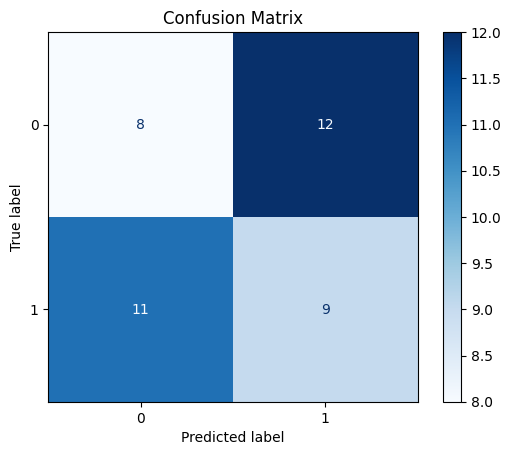

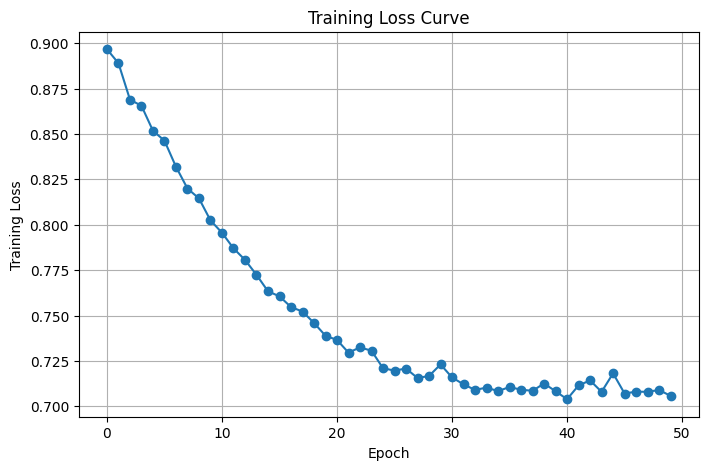

In [50]:
# Load synthetic genomics data with signal
features, labels = load_genomics_kg_features(num_samples=200, feature_dim=16, threshold=8.0)

# Split data into training (80%) and testing (20%) sets
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, random_state=42)

print(f"\nTraining features shape: {train_features.shape}")
print(f"Testing features shape: {test_features.shape}")

# Define model hyperparameters
input_dim = train_features.shape[1]
hidden_dim = 32
num_quantum_params = 4  # for our error-corrected circuit
num_classes = 2  # binary classification

# Initialize the hybrid model with quantum error correction enabled
model = HybridGenomicsLLM(input_dim, hidden_dim, num_quantum_params, num_classes, use_error_correction=True)

print("\n=== Training Hybrid Quantum-Classical Model with Quantum Error Correction ===")
loss_history = train_model(train_features, train_labels, model, num_epochs=50)

print("\n=== Testing Hybrid Quantum-Classical Model with Quantum Error Correction ===")
test_loss, test_accuracy = test_model(test_features, test_labels, model)

# Plot training loss curve
plt.figure(figsize=(8,5))
plt.plot(loss_history, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()
